In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from lhotse import CutSet, Fbank, LilcomFilesWriter
from lhotse.augmentation import SoxEffectTransform, RandomValue, pitch, reverb, speed
from lhotse.dataset import K2SpeechRecognitionDataset
from lhotse.dataset.sampling import SimpleCutSampler
from lhotse.recipes.librispeech import download_librispeech, prepare_librispeech

# Select data parts

In [2]:
mini_librispeech = False

In [3]:
if mini_librispeech:
    dataset_parts = 'mini_librispeech'
    dev_set = 'dev-clean-2'
    train_set = 'train-clean-5'
else:
    dataset_parts = ('dev-clean', 'test-clean', 'train-clean-100')
    dev_set = 'dev-clean'
    train_set = 'train-clean-100'

# Settings for paths

In [4]:
root_dir = Path('data')
corpus_dir = root_dir / 'LibriSpeech'
output_dir = root_dir / 'librispeech_nb'

# Download and untar

In [5]:
download_librispeech(root_dir, dataset_parts)

# Prepare audio and supervision manifests

In [6]:
num_jobs = os.cpu_count()

In [7]:
librispeech_manifests = prepare_librispeech(corpus_dir, dataset_parts, output_dir, num_jobs=num_jobs)

# [Optional] Data augmentation

In [8]:
use_data_augmentation = False
augment_fn = SoxEffectTransform(effects=[
   ['reverb', 50, 50, RandomValue(0, 100)],
   ['remix', '-'],  # Merge all channels (reverb changes mono to stereo)
   ['rate', 16000],
]) if use_data_augmentation else None

# Extract features

In [9]:
for partition, manifests in librispeech_manifests.items():
    manifest_path = output_dir / f'cuts_{partition}.json.gz'
    if not manifest_path.is_file():
        with ProcessPoolExecutor(num_jobs) as ex:
            cut_set = CutSet.from_manifests(
                recordings=manifests['recordings'],
                supervisions=manifests['supervisions']
            )
            if use_data_augmentation:
                cut_set = cut_set + cut_set.perturb_speed(0.9) + cut_set.perturb_speed(1.1)
            cut_set = cut_set.compute_and_store_features(
                extractor=Fbank(),
                storage_path=f'{output_dir}/feats_{partition}',
                storage_type=LilcomFilesWriter,
                augment_fn=augment_fn,
                num_jobs=num_jobs,
                executor=ex
            )
        librispeech_manifests[partition]['cuts'] = cut_set
        cut_set.to_json(manifest_path)
    librispeech_manifests[partition] = CutSet.from_json(manifest_path)

# Make PyTorch Dataset

In [10]:
dataset_dev = K2SpeechRecognitionDataset(librispeech_manifests[dev_set])
dataset_train = K2SpeechRecognitionDataset(librispeech_manifests[train_set])

# Illustration of an example

In [11]:
sampler = SimpleCutSampler(dataset_dev.cuts, shuffle=False, max_cuts=4)
cut_ids = next(iter(sampler))
sample = dataset_dev[cut_ids]

Transcript: I'M HERE BECAUSE THE MATTER IS OF UTMOST IMPORTANCE AND BRANDD IS THE ONE I MUST SEE NOW STAND ASIDE
Supervisions start frame: 0
Supervisions frame number: 774
Feature matrix:


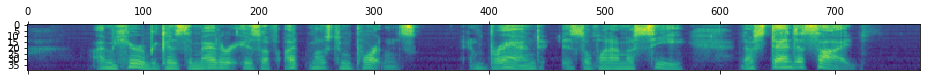

In [12]:
print('Transcript:', sample['supervisions']['text'][0])
print('Supervisions start frame:', int(sample['supervisions']['start_frame'][0]))
print('Supervisions frame number:', int(sample['supervisions']['num_frames'][0]))
print('Feature matrix:')
plt.matshow(sample['inputs'][0].transpose(0, 1).flip(0));

# Make PyTorch Dataloader

In [13]:
dev_dl = torch.utils.data.DataLoader(dataset_dev, batch_size=None, sampler=sampler)

In [14]:
for batch in dev_dl:
    for key, value in batch.items():
        print(key, '- shape or length:', end=' ')
        if isinstance(value, torch.Tensor):
            print(value.shape)
        else:
            print(len(value))
    break

inputs - shape or length: torch.Size([4, 774, 40])
supervisions - shape or length: 4
